In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing Libraries
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras as k
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,BatchNormalization,Activation,GlobalAveragePooling2D,Dropout,Dense,MaxPooling2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from PIL import Image
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [3]:
# Load dataset directories
train = 'rafdb/DATASET/train'
test = 'rafdb/DATASET/test'

In [4]:
img_size=(100,100)
bth_size=32

# Augmenting Images for training set

trdatagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.1
)

# Normalization of the pixel values for test Set
tedatagen = ImageDataGenerator(rescale=1.0/255)

In [5]:
# Reading the training data from directory

traingen= trdatagen.flow_from_directory(
    train,
    target_size=img_size,
    batch_size=bth_size,
    color_mode='grayscale',  
    class_mode='categorical',
    shuffle=True,
    subset='training')

# Reading the testing data from directory

testgen = tedatagen.flow_from_directory(
    test,
    target_size=img_size,
    batch_size=bth_size,
    color_mode='grayscale', 
    class_mode='categorical',
    shuffle=False
)

Found 11046 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.


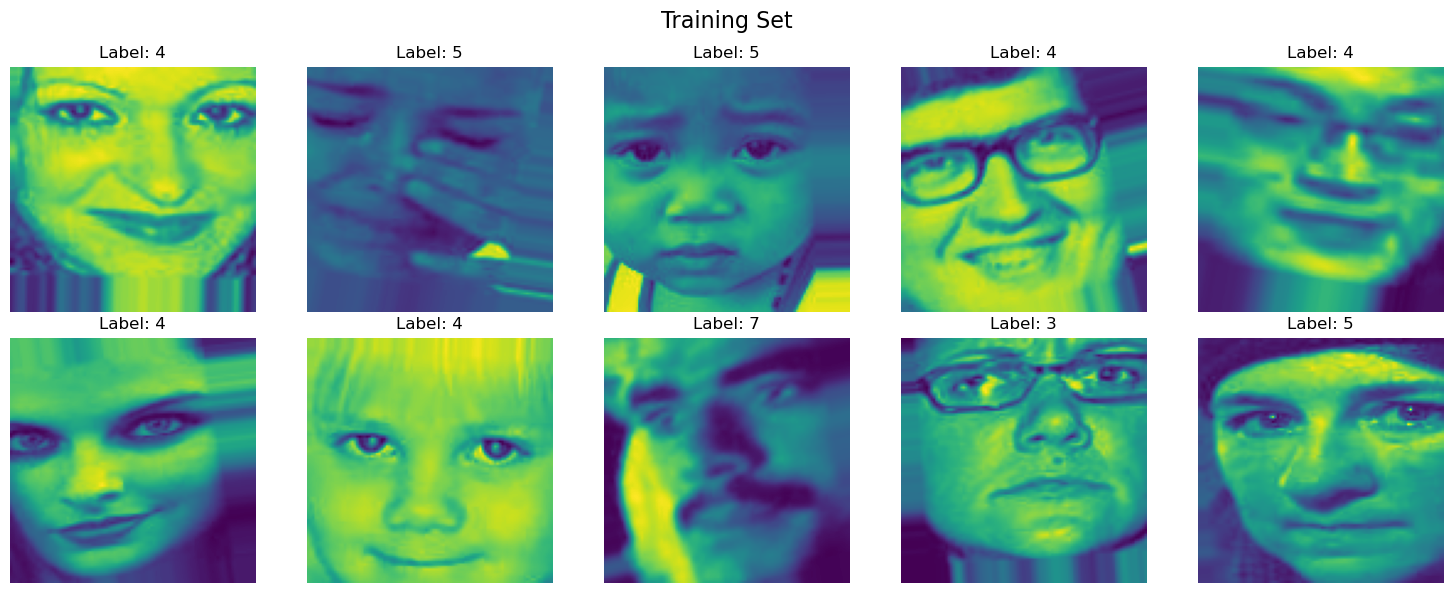

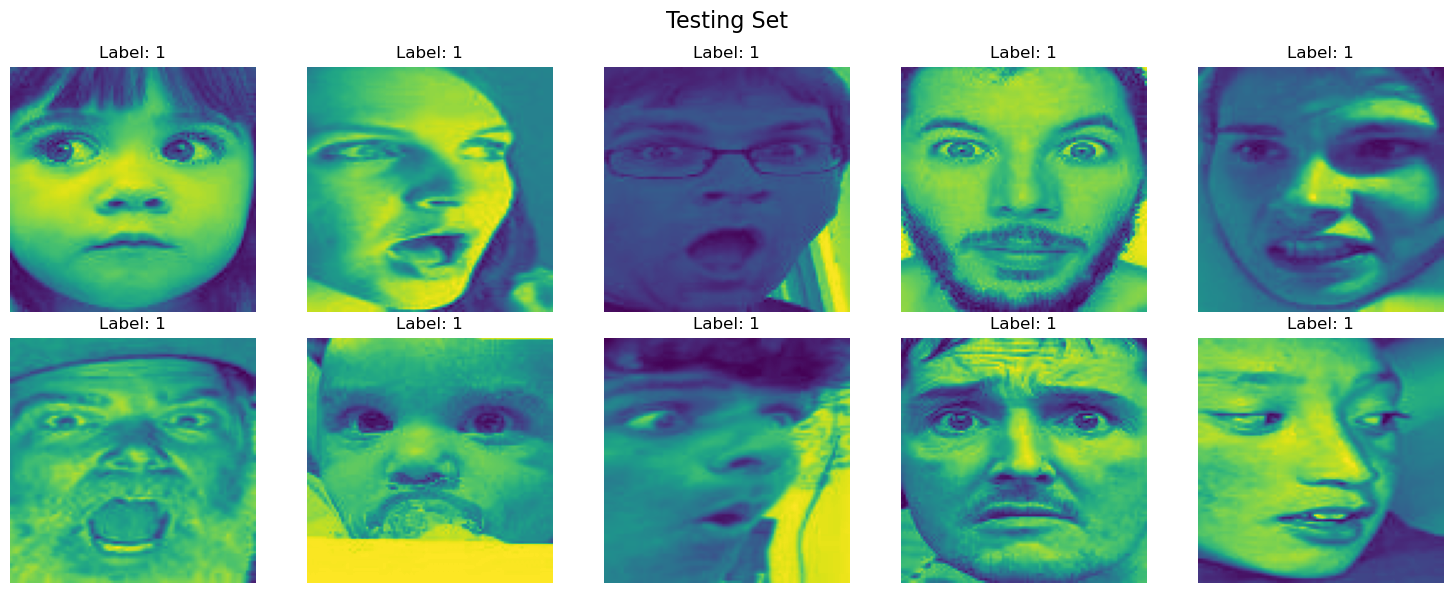

In [6]:
# Displaying the training and testing datsets (only 5 images from each dataset)

def plot_images_from_generator(generator, title, num_images=5, images_per_row=5):
    images, labels = next(generator)
    images = images[:num_images]
    labels = labels[:num_images]
    num_rows = (num_images + images_per_row - 1) // images_per_row
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    for i in range(num_images):
        img = images[i]
        label = labels[i]
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {list(generator.class_indices.keys())[label.argmax()]}")
    
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_images_from_generator(traingen, "Training Set", num_images=10, images_per_row=5)
plot_images_from_generator(testgen, "Testing Set", num_images=10, images_per_row=5)

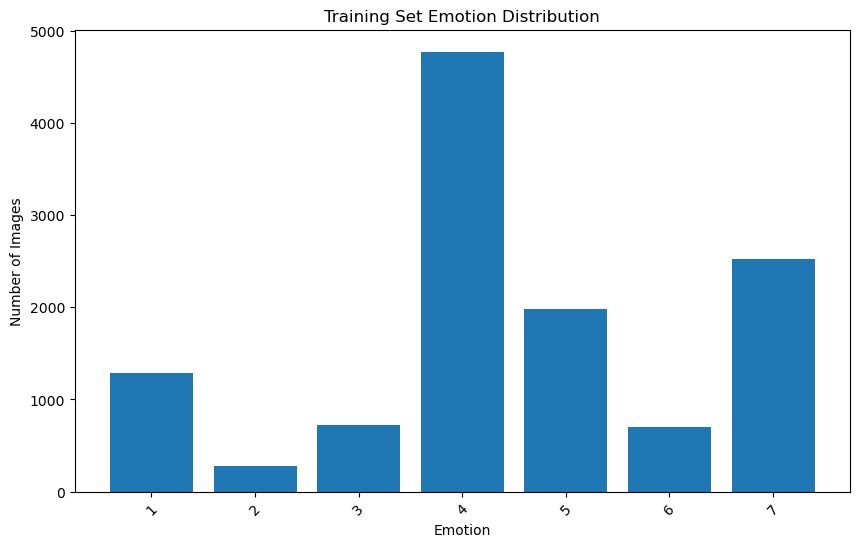

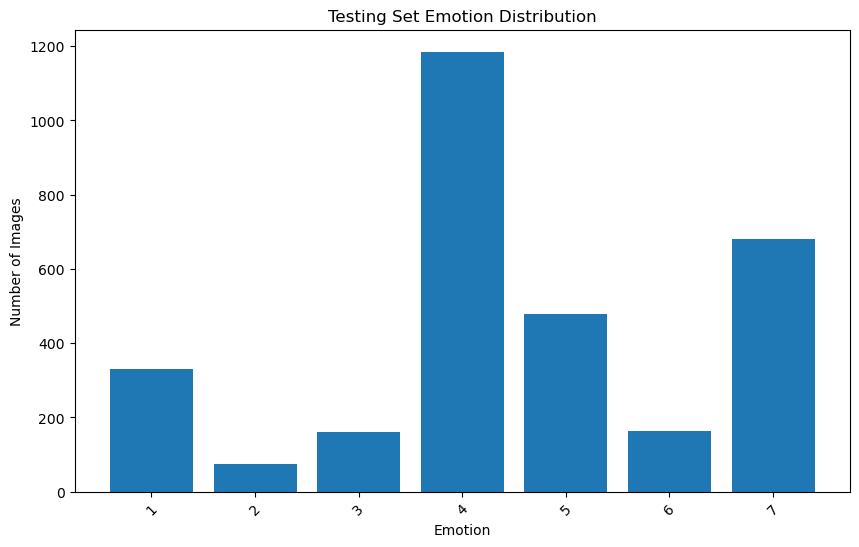

In [7]:
#class distribution

def plot_class_distribution(directory, title):
    class_names = os.listdir(directory)
    class_counts = []
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts.append(len(os.listdir(class_dir)))

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_counts)
    plt.title(title)
    plt.xlabel('Emotion')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution('rafdb/DATASET/train', "Training Set Emotion Distribution")
plot_class_distribution('rafdb/DATASET/test', "Testing Set Emotion Distribution")

In [8]:
# Label Map
label_map = {
    0:'Angry', 
    1:'Disgust',
    2:'Fear',
    3:'Happy', 
    4:'Sad', 
    5:'Surprise', 
    6:'Neutral'
}

In [9]:
# Learning rate schedule for better training control
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)

optimizer = Adam(learning_rate=0.001)

In [10]:
# Defining CNN model

model = Sequential()
model.add(Input(shape=(100, 100, 1)))

# Block 1
model.add(SeparableConv2D(64, (3, 3), padding='same',
                          depthwise_initializer='he_normal', pointwise_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(SeparableConv2D(64, (3, 3), padding='same',
                          depthwise_initializer='he_normal', pointwise_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 2
model.add(SeparableConv2D(128, (3, 3), padding='same',
                          depthwise_initializer='he_normal', pointwise_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(SeparableConv2D(128, (3, 3), padding='same',
                          depthwise_initializer='he_normal', pointwise_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 3
model.add(SeparableConv2D(256, (3, 3), padding='same',
                          depthwise_initializer='he_normal', pointwise_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(SeparableConv2D(256, (3, 3), padding='same',
                          depthwise_initializer='he_normal', pointwise_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 4
model.add(SeparableConv2D(512, (3, 3), padding='same',
                          depthwise_initializer='he_normal', pointwise_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(SeparableConv2D(512, (3, 3), padding='same',
                          depthwise_initializer='he_normal', pointwise_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Increased dropout for better regularization

model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d                │ (None, 100, 100, 64)   │           137 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 100, 100, 64)   │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 50, 50, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 50, 50, 128)    │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 25, 25, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 25, 25, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 25, 25, 256)    │        68,09

 Total params: 9,985,872 (38.09 MB)

 Trainable params: 9,981,008 (38.07 MB)

 Non-trainable params: 4,864 (19.00 KB)

In [11]:
#Implementing Early Stopping and Learning Rate Reduction
es=EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)
lr=ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, verbose=1, min_delta=0.0001)

callbacks_list=[es,lr]

In [12]:
history = model.fit(
    traingen,
    epochs=100,
    validation_data=testgen,
    callbacks=callbacks_list
)

C:\Users\RAVI RAJ\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 338s 896ms/step - accuracy: 0.3071 - loss: 2.0694 - val_accuracy: 0.3862 - val_loss: 1.7739 - learning_rate: 0.0010
Epoch 2/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 298s 861ms/step - accuracy: 0.3917 - loss: 1.6574 - val_accuracy: 0.4733 - val_loss: 1.3805 - learning_rate: 0.0010
Epoch 3/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 297s 858ms/step - accuracy: 0.4462 - loss: 1.4860 - val_accuracy: 0.5769 - val_loss: 1.1651 - learning_rate: 0.0010
Epoch 4/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 221s 638ms/step - accuracy: 0.5154 - loss: 1.3178 - val_accuracy: 0.5935 - val_loss: 1.1598 - learning_rate: 0.0010
Epoch 5/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 187s 540ms/step - accuracy: 0.5684 - loss: 1.1935 - val_accuracy: 0.6604 - val_loss: 0.9457 - learning_rate: 0.0010
Epoch 6/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 187s 539ms/step - accuracy: 0.5926 - loss: 1.1124 - val_accuracy: 0.6819 - val_loss: 0.8961 - learning_rate: 0.0010
Epoch 7/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 186s 538ms/step -

In [13]:
#Predicting
test_loss, test_accuracy = model.evaluate(testgen)

96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.8098 - loss: 0.5983


Test Accuracy: 0.83
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       329
           1       0.69      0.58      0.63        74
           2       0.49      0.42      0.46       160
           3       0.96      0.90      0.93      1185
           4       0.77      0.85      0.81       478
           5       0.69      0.79      0.74       162
           6       0.79      0.82      0.80       680

    accuracy                           0.83      3068
   macro avg       0.75      0.74      0.74      3068
weighted avg       0.83      0.83      0.83      3068

Confusion Matrix:
[[ 276   11    2    4    8    7   21]
 [  10   43    3    1   10    4    3]
 [   7    2   68   10   26   18   29]
 [  11    3   15 1068   19   15   54]
 [   2    1   19    9  408    7   32]
 [   2    2   12    5    2  128   11]
 [  20    0   19   19   60    6  556]] 




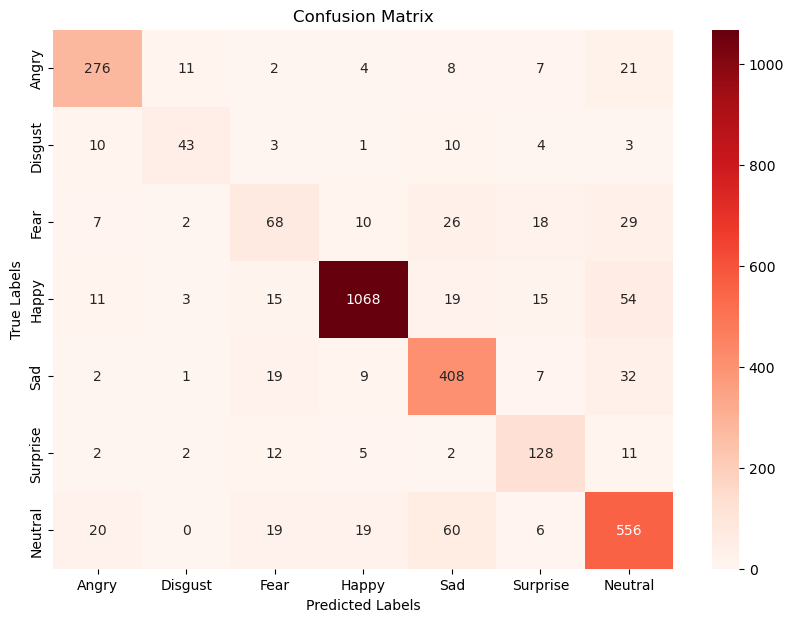

Training class indices: {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6}
Test class indices: {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6}


In [14]:
print(f"Test Accuracy: {test_accuracy:.2f}")
y_pred = np.argmax(model.predict(testgen), axis=1)
y_true = testgen.classes
print("Classification Report:")
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix,'\n\n')
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', 
            xticklabels=list(label_map.values()), 
            yticklabels=list(label_map.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print("Training class indices:", traingen.class_indices)
print("Test class indices:", testgen.class_indices)

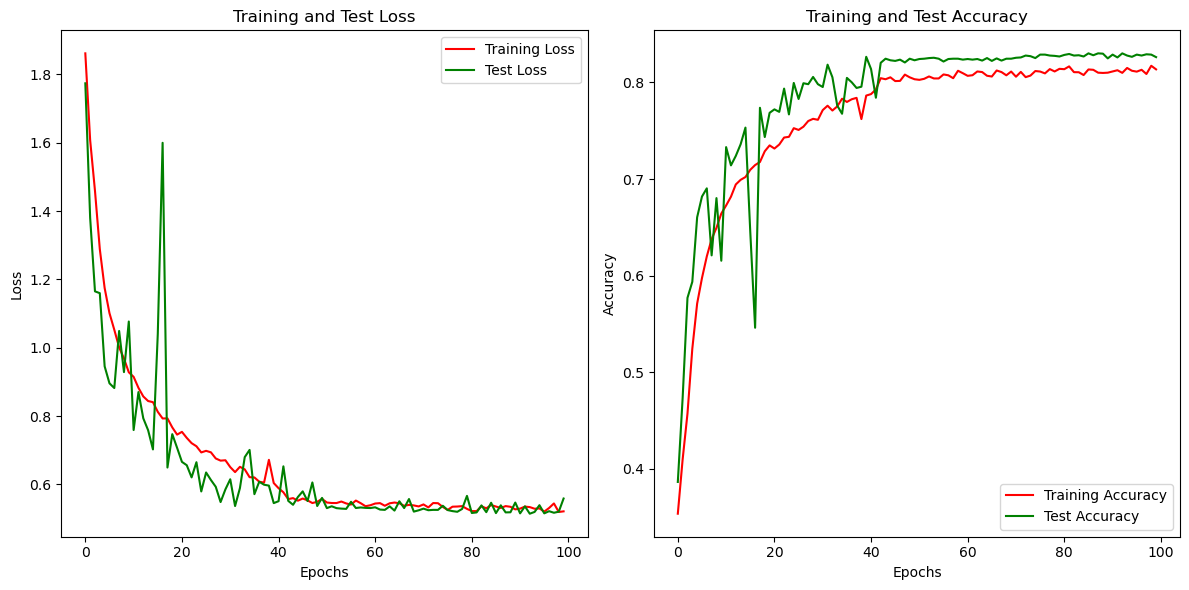

In [15]:
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Test Loss', color='green')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', color='green')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step


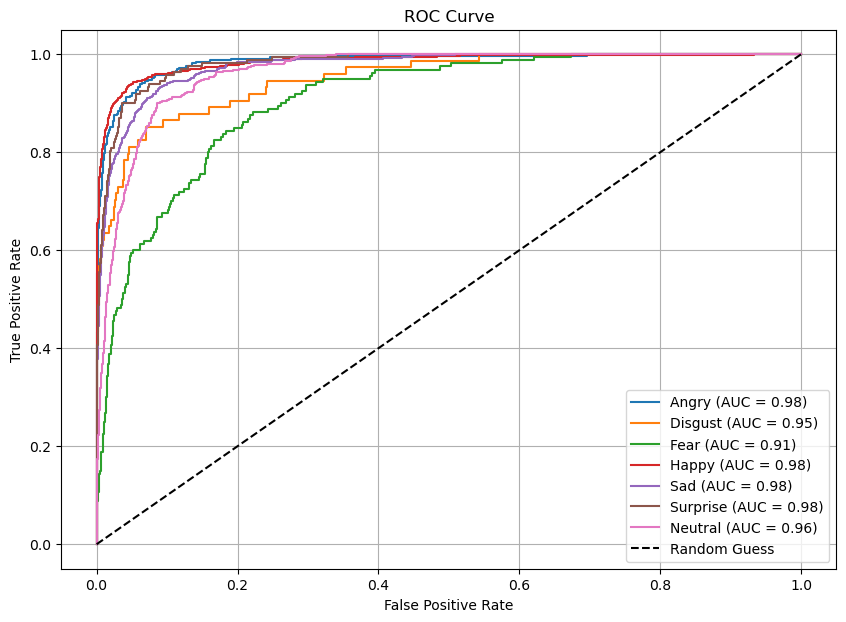

In [16]:
# Convert true labels to one-hot encoding for ROC calculations
y_true_onehot = label_binarize(y_true, classes=[0, 1, 2, 3, 4,5,6])
y_pred_prob = model.predict(testgen)

plt.figure(figsize=(10, 7))

# Plot ROC for each class
for i, class_name in label_map.items():
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()